In this example, we will demonstrate Cantera's ability to handle non-ideal gas equations of state.  This particular example will use a multi-component Redlich-Kwong Equation of state:
$$p = \frac{RT}{v - b} - \frac{a}{v\sqrt{T}\left(v+b\right)}$$
and will compare results to an ideal gas approximation:
$$pv = RT$$
We will compare various properties of a mixture CO$_2$, H$_2$O, H$_2$, and CO.

First, import the necessary Python modules:

In [1]:
import cantera as ct
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

For the first example, we will construct the phase diagram in the saturated liquid-vapor region for a mixture that is 99% CO$_2$, 1% H$_2$ (by mole).

First identify the range of temperature and pressure values.  Store the number of pressures and temperatures, and initialize the matrix of specific volume (m$^3$/kg) values.

In [2]:
Temps = np.array(range(282,380,2));
press = 7.38937e6*np.array([0.5,0.75,0.9,1.0,1.1,1.25,1.54,1.75,2,5,10]);
npress = press.size
ntemp = Temps.size
v_spec = np.zeros((npress,ntemp))

First, we will construct the "phase diagram" using an ideal gas object, in Cantera.  Start by loading the gas object from the input file:

In [3]:
Ideal_gas = ct.Solution('input-fiels/non-ideal-models/co2_RK_example.cti','carbondioxide_ideal')

Now loop over the temperatures and pressures, and store the specific volume at each set of conditions:

In [4]:
for i in np.arange(npress):
    Pres = press[i]
    for j in np.arange(ntemp):
        temp = Temps[j]
        Ideal_gas.TP = temp, Pres
        v_spec[i,j] = 1/Ideal_gas.density

We plot the results, seeing that (as expected) the ideal gas model is incapable of predicting phase change.

<IPython.core.display.Javascript object>


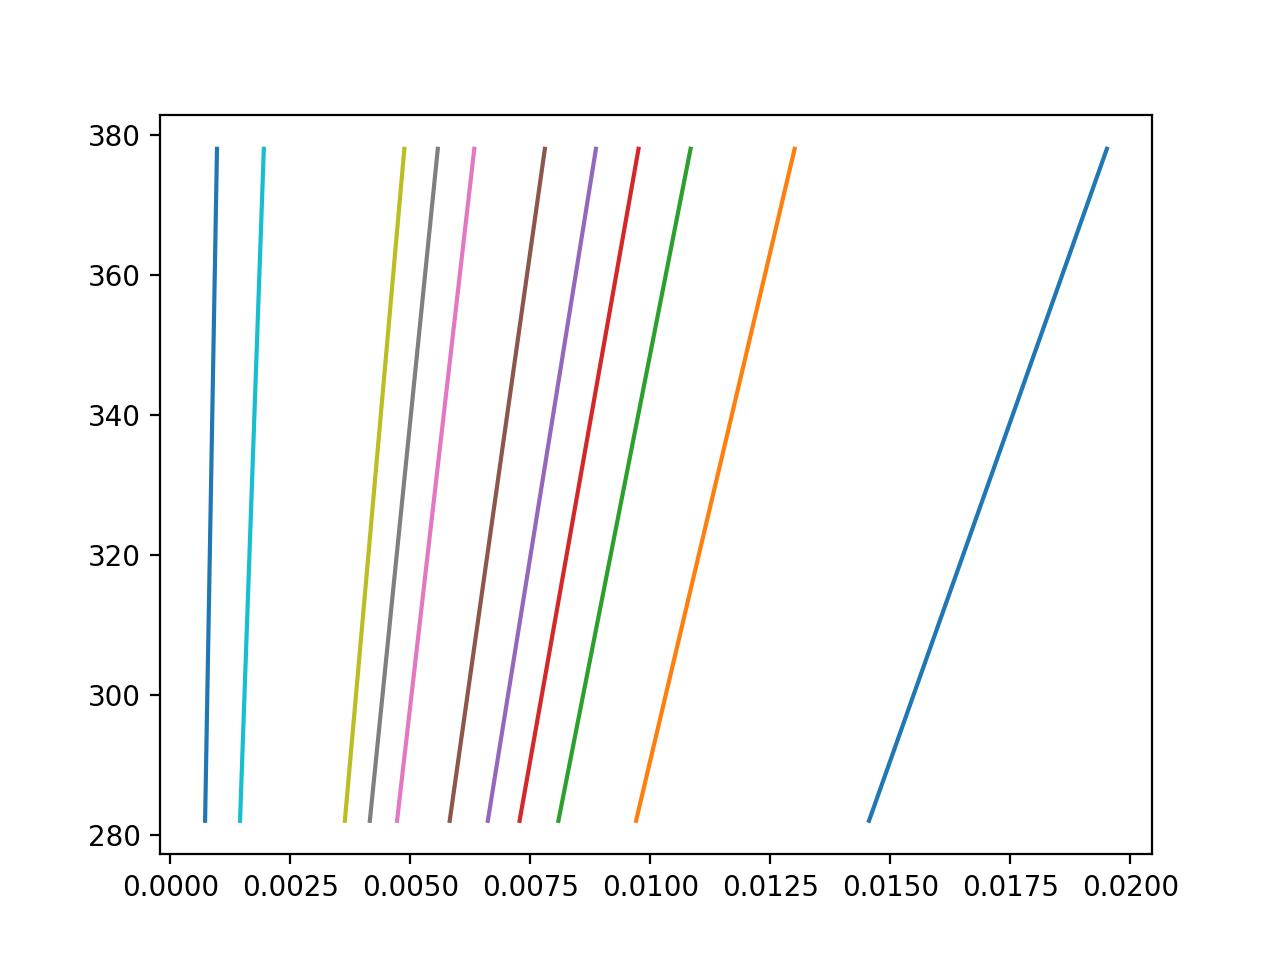

In [5]:
plt.figure()
plt.plot(np.transpose(v_spec), Temps)
plt.show()

Repeat the process for a non-ideal Redlich-Kwong equation of state:

In [6]:
RK_gas = ct.Solution('input-files/non-ideal-models/co2_RK_example.cti','carbondioxide')

In [7]:
for i in np.arange(npress):
    Pres = press[i]
    for j in np.arange(ntemp):
        temp = Temps[j]
        RK_gas.TP = temp, Pres
        v_spec[i,j] = 1/RK_gas.density

<IPython.core.display.Javascript object>


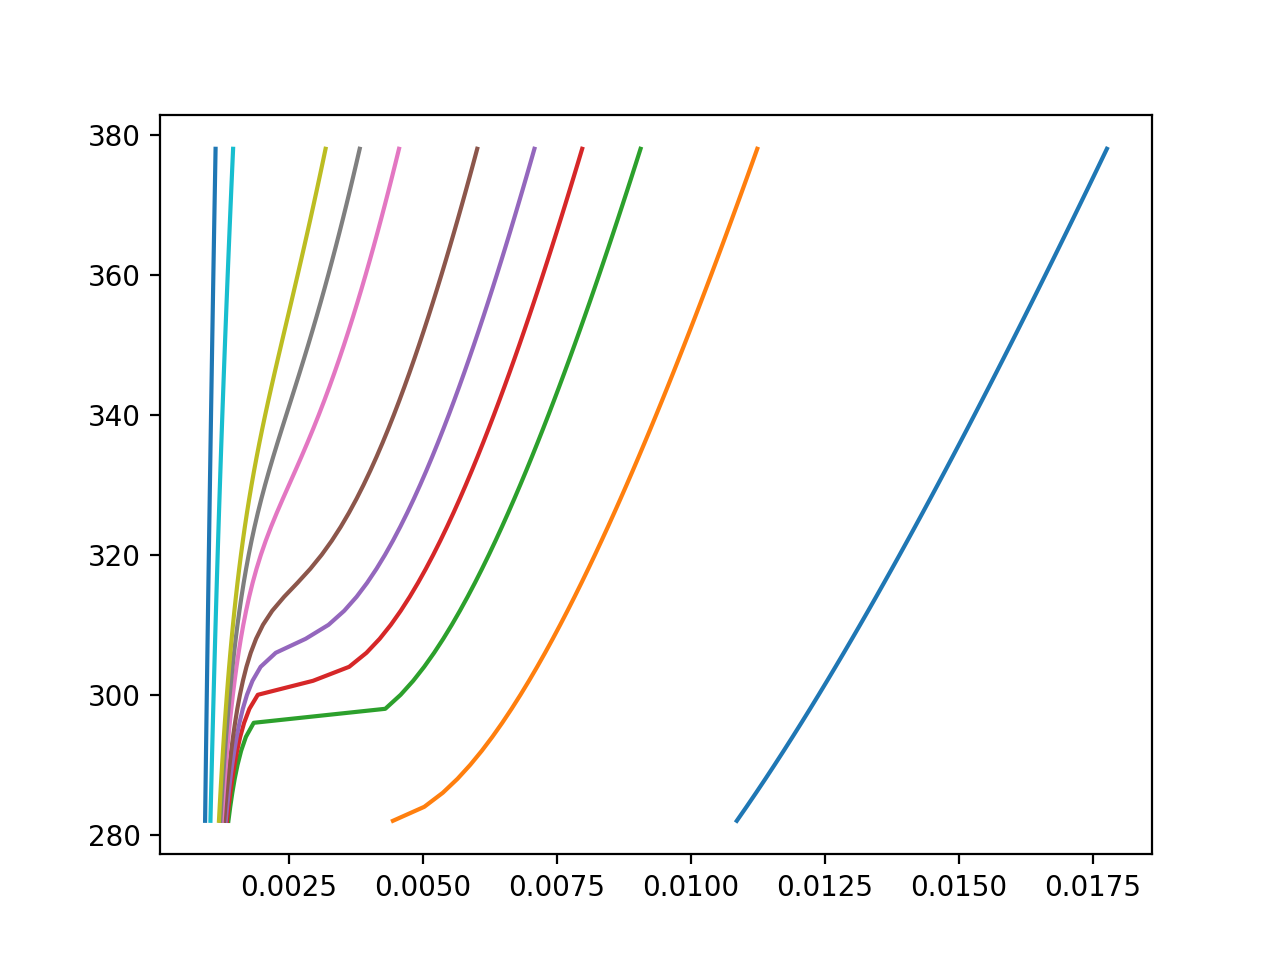

In [8]:
plt.figure()
plt.plot(np.transpose(v_spec),Temps)#,'D')
plt.show()

Now we see the expected behavior, with phase change below the critical point, and a continuous change of properties for the supercritical fluid.

In [9]:
RK_gas.equilibrate('HP')

In [10]:
RK_gas()


  carbondioxide:

       temperature         386.859  K
          pressure     7.38937e+07  Pa
           density         871.329  kg/m^3
  mean mol. weight         43.8089  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -9.0323e+06       -3.957e+08     J
   internal energy     -9.1171e+06       -3.994e+08     J
           entropy          3572.1        1.565e+05     J/K
    Gibbs function     -1.0414e+07       -4.562e+08     J
 heat capacity c_p          1434.6        6.285e+04     J/K
 heat capacity c_v          967.79         4.24e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
               CO2       0.992462         0.997014         -142.305
               H2O     0.00502499        0.0020664         -98.6436
                H2    3.03262e-07      1.39547e-08         -22.8833
                CO

For the second example, we will compare reaction rates of progress for the water-gas shift reaction:

$${\rm H}_2{\rm O} + {\rm CO} \leftrightarrow {\rm CO}_2 + {\rm H}_2$$.

These will be calculated for a zero-D reactor.  Simulations will have an initial condition of $T =$ 800 K, and a composition of 50% CO$_2$, 50% H$_2$.  Start at low pressure (1 atmosphere).  Load the initial conditions to each gas object, and create the reactor and reactor network for each.  Initialize lists to store the H$_2$ mole fraction and the simulation time:

In [11]:
RK_gas.TPX = 800, 101325, {'CO2':0.5, 'H2':0.5}
Ideal_gas.TPX = 800, 101325, {'CO2':0.5, 'H2':0.5}

r_RK = ct.Reactor(contents=RK_gas,name='RK reactor')
reactorNetwork_RK = ct.ReactorNet([r_RK])

r_IG = ct.IdealGasReactor(contents=Ideal_gas,name='IG reactor')
reactorNetwork_IG = ct.ReactorNet([r_IG])

X_RK = list()
X_IG = list()

times_RK = list()
times_IG = list()

Integrate the reactors:

In [12]:
t_RK = 0
t_IG = 0
while(t_RK < 100):
    t_RK = reactorNetwork_RK.step()   
    times_RK.append(t_RK)
    X_RK.append(RK_gas.X[2])
while(t_IG < 100):
    t_IG = reactorNetwork_IG.step() 
    times_IG.append(t_IG)
    X_IG.append(Ideal_gas.X[2])

Plotting the results, we see that the two equations of state agree exactly at low pressure:

<IPython.core.display.Javascript object>


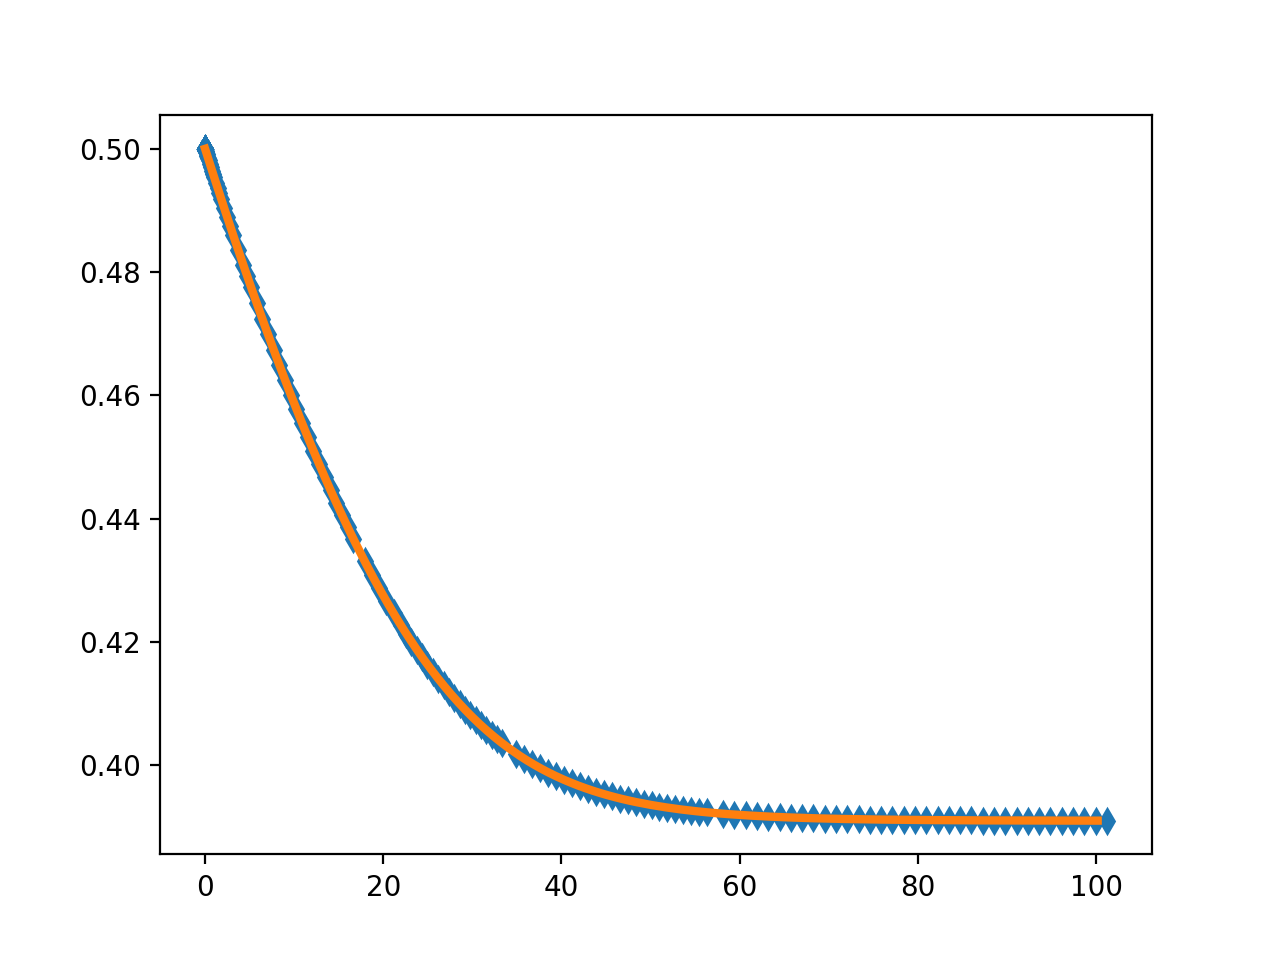

In [13]:
plt.figure()
plt.plot(times_RK,X_RK,'d')
plt.plot(times_IG,X_IG,linewidth=3.0)
plt.show()

Now repeat the process at a very high pressure (100 atmospheres).

In [14]:
RK_gas.TPX = 800, 100*101325, {'CO2':0.5, 'H2':0.5}
Ideal_gas.TPX = 800, 100*101325, {'CO2':0.5, 'H2':0.5}

r_RK = ct.Reactor(contents=RK_gas,name='RK reactor')
reactorNetwork_RK = ct.ReactorNet([r_RK])

r_IG = ct.IdealGasReactor(contents=Ideal_gas,name='IG reactor')
reactorNetwork_IG = ct.ReactorNet([r_IG])


X_RK = list()
X_IG = list()

times_RK = list()
times_IG = list()

In [15]:
t_RK = 0
t_IG = 0
while(t_RK < 50):
    t_RK = reactorNetwork_RK.step()   
    times_RK.append(t_RK)
    X_RK.append(RK_gas.X[2])
while(t_IG < 50):
    t_IG = reactorNetwork_IG.step() 
    times_IG.append(t_IG)
    X_IG.append(Ideal_gas.X[2])

<IPython.core.display.Javascript object>


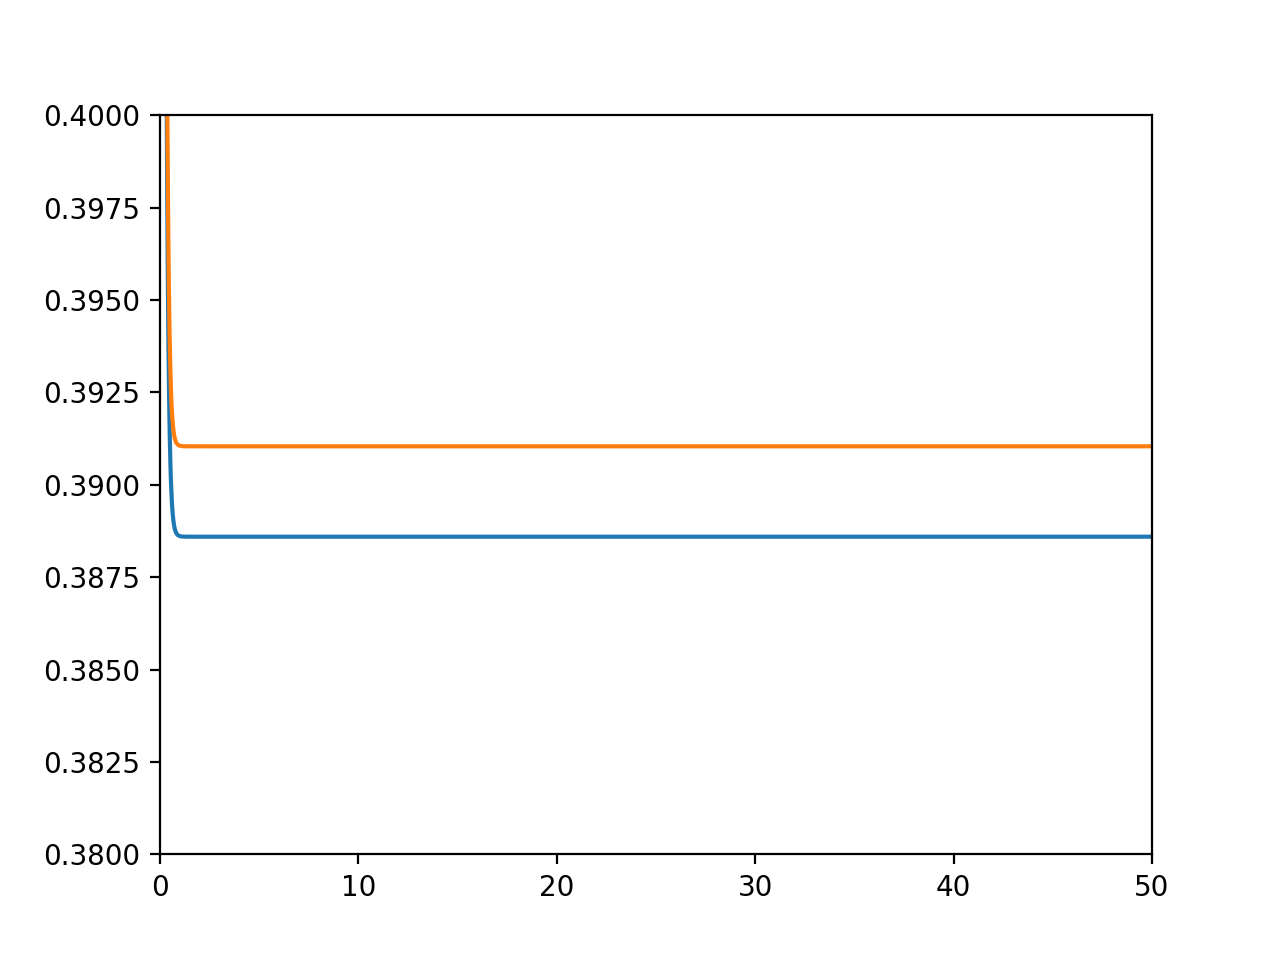

In [16]:
plt.figure()
plt.plot(times_RK,X_RK)
plt.plot(times_IG,X_IG)
plt.xlim([0,50])
plt.ylim([0.38,0.40])
plt.show()

While the difference between the two models is rather small, there are a number of other situations where non-idealities will have a more significant impact.